# Pinocchio + CasADi: variational integrators

## Variational integrators: introduction

$$
\newcommand{\bfm}[1]{\mathbf{#1}}
$$

We're going to implement an integrator following [Murphey's 2009 paper](https://murpheylab.github.io/pdfs/2009TROJoMuextended.pdf).

The idea is as follows: the continuous Euler-Lagrange equation underpinning classical analytical mechanics can be used to derive the Newton-Euler equation in generalized coordinates,
$$
    M(\bfm{q})\bfm{\ddot q} + h(\bfm q, \bfm{\dot q}) = \boldsymbol{\tau}
$$
These equations are often discretized using methods for DAEs or ODEs, by introducing the acceleration
$$
    \bfm{a} = M(\bfm{q})^{-1}(\boldsymbol\tau - h(\bfm{q}, \bfm{\dot{q}})) \triangleq \mathrm{ABA}(\bfm q, \bfm{\dot{q}}, \boldsymbol\tau)
$$
where ABA standard for "articulated body algorithm", and using standard integrators like semi-implicit Euler, Runge-Kutta...

The Euler-Lagrange equation itself (with external forces) reads
$$
    \frac{d}{dt}\frac{\partial \mathcal L}{\partial \bfm{\dot q}} = \frac{\partial\mathcal L}{\partial\bfm{q}} + \boldsymbol{\tau}
$$
where $ \mathcal L(\bfm q, \bfm{\dot q}) = T(\bfm{q}, \bfm{\dot q}) - V(\bfm{q}) $ is the dynamical system's Lagrangian. It is derived from the Lagrange-d'Alembert principle
\begin{equation}
    \delta S + \int_{t_0}^{t_f} \boldsymbol{\tau} \cdot \delta \bfm{q}\, dt = 0
    \tag{P}
\end{equation}
where $ S(\bfm q) = \int_{t_0}^{t_f} L(\bfm q, \bfm{\dot q})\,dt $ is the action integral.

**_Variational integrators_** rely on a direct discretization of principle (P) instead of discretizing the Euler-Lagrange equation itself.
The resulting condition is the discrete Euler-Lagrange (DEL) equation
$$
    \partial_2L_d(\bfm{q}_{k-1}, \bfm{q}_{k}) + \partial_1L_d(\bfm{q}_k, \bfm{q}_{k+1}) + \Delta t\boldsymbol{\tau}_k = 0
$$

The function $L_d$ is the _discrete Lagrangian_, which is a quadrature term for the action, for instance using the midpoint rule:
$$
    L_d(\bfm{q}_k, \bfm{q}_{k+1}) = L(\bfm{\bar{q}}, \tilde{\bfm{v}})\Delta t,\quad
    \bfm{\bar{q}} = \mathrm{interpolate}(\bfm q_k, \bfm{q}_{k+1}, 1/2), \
    \tilde{\bfm{v}} = \frac{\bfm{q}_{k+1} \ominus \bfm{q}_k}{\Delta t}.
$$
(Alternatives are possible for instance using the trapezoidal rule). We have that
$$
    S(\bfm q) \approx \sum_{k=0}^{N-1} L_d(\bfm{q}_k, \bfm{q}_{k+1}).
$$

In [1]:
import casadi
import hppfcl as fcl
import numpy as np
import pinocchio as pin
import pinocchio.casadi as cpin
from casadi import SX

In [2]:
def makeModel():
    model = pin.Model()
    geom_model = pin.GeometryModel()

    RED_COLOR = np.array([1.0, 0.1, 0.1, 1.0])
    WHITE_COLOR = np.ones(4)

    joint_pl = pin.SE3.Identity()
    mass = 1.0
    radius_base = 0.08
    shape0 = fcl.Sphere(radius_base)
    geom_obj = pin.GeometryObject("base", 0, shape0, pin.SE3.Identity())
    geom_obj.meshColor = RED_COLOR
    geom_model.addGeometryObject(geom_obj)

    parent_id = 0

    for k in range(2):
        # define joint and body
        j_name = f"joint{k}"
        j_id = model.addJoint(parent_id, pin.JointModelRY(), joint_pl, j_name)

        radius = 0.06
        mass = 0.5
        length = 1.0

        body_pl = joint_pl.copy()
        body_pl.translation[2] = length  # at end of joint
        inertia = pin.Inertia.FromSphere(mass, radius)
        model.appendBodyToJoint(j_id, inertia, body_pl)

        # add geometry
        geom_name = f"ball{k}"
        shape = fcl.Sphere(radius)
        geom_obj = pin.GeometryObject(geom_name, j_id, shape, body_pl)
        geom_obj.meshColor = RED_COLOR
        geom_model.addGeometryObject(geom_obj)

        geom_name2 = f"capsule{k}"
        geom_pl2 = body_pl.copy()
        geom_pl2.translation = np.array([0.0, 0.0, length / 2])
        shape2 = fcl.Cylinder(radius / 3, length)
        geom_obj2 = pin.GeometryObject(geom_name2, j_id, shape2, geom_pl2)
        geom_obj2.meshColor = WHITE_COLOR
        geom_model.addGeometryObject(geom_obj2)

        parent_id = j_id
        joint_pl = body_pl.copy()

    return model, geom_model

In [3]:
model, geom_model = makeModel()
model

Nb joints = 3 (nq=2,nv=2)
  Joint 0 universe: parent=0
  Joint 1 joint0: parent=0
  Joint 2 joint1: parent=1

In [4]:
from pinocchio.visualize import MeshcatVisualizer

In [5]:
vizer = MeshcatVisualizer(model, geom_model, visual_model=geom_model)

In [6]:
vizer.initViewer()
vizer.loadViewerModel("pinocchio")

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [7]:
q0 = pin.neutral(model)
vizer.display(q0)

In [8]:
vizer.viewer.jupyter_cell()

In [9]:
# define the timestep
timestep = 0.01

In [10]:
# define the system Lagrangian's graph


def continuousLagrangian(model, data, q, v, ns=cpin):
    return ns.computeKineticEnergy(model, data, q, v) - ns.computePotentialEnergy(
        model, data, q
    )


def discreteLagrangian(model, data, q0, q1, alpha=0.5, ns=cpin):
    q = ns.interpolate(model, q0, q1, alpha)
    v = ns.difference(model, q0, q1) / timestep
    return continuousLagrangian(model, data, q, v, ns=ns) * timestep


## define the symbols
cmodel = cpin.Model(model)
cdata = cmodel.createData()

cq0 = SX.sym("q0", model.nq)
cq1 = SX.sym("q1", model.nq)
cq2 = SX.sym("q2", model.nq)
cdq0_ = SX.sym("dq0_", model.nv)
cdq1_ = SX.sym("dq1_", model.nv)
cdq2_ = SX.sym("dq2_", model.nv)

# control symbol
nu = model.nv  # assume fully-actuated
cu = SX.sym("u", nu)

In [11]:
def create_residual_expr():
    cq0_int = cpin.integrate(cmodel, cq0, cdq0_)
    cq1_int = cpin.integrate(cmodel, cq1, cdq1_)
    cq2_int = cpin.integrate(cmodel, cq2, cdq2_)

    Ld_curr = discreteLagrangian(cmodel, cdata, cq0_int, cq1_int)
    Ld_next = discreteLagrangian(cmodel, cdata, cq1_int, cq2_int)
    D2Ld_curr = casadi.gradient(Ld_curr, cdq1_)
    D1Ld_next = casadi.gradient(Ld_next, cdq1_)
    Fd = timestep * cu  # rectangle rule

    residual = D2Ld_curr + D1Ld_next + Fd
    return residual


residual = create_residual_expr()
nv = model.nv
cargs = [cq0, cq1, cq2, cu, cdq0_, cdq1_, cdq2_]
fused_dq = casadi.vertcat(cdq0_, cdq1_, cdq2_)
carg_names = ["q0", "q1", "q2", "u", "dq0_", "dq1_", "dq2_"]

residual_fun = casadi.Function(
    "f",
    cargs[:4],
    [casadi.substitute(residual, fused_dq, SX.zeros(nv + nv + nv))],
    carg_names[:4],
    ["f"],
)
residual_fun

Function(f:(q0[2],q1[2],q2[2],u[2])->(f[2]) SXFunction)

In [12]:
residual_fun(pin.neutral(model), pin.neutral(model), pin.neutral(model), np.ones(nu))

DM([0.01, 0.01])

In [13]:
def make_jacobian_fun_all():
    # define a function to compute the Jacobians of the residual
    # wrt variables q0, q1, q2 and u
    fused_args = casadi.vertcat(fused_dq, cu)

    jac_residual_expr_full = casadi.jacobian(residual, fused_args)
    nv = model.nv
    jac_residual_blocks = [
        jac_residual_expr_full[:, :nv],
        jac_residual_expr_full[:, nv : 2 * nv],
        jac_residual_expr_full[:, 2 * nv : 3 * nv],
        jac_residual_expr_full[:, 3 * nv :],
    ]
    jac_residual_blocks = [
        casadi.substitute(J, fused_dq, SX.zeros(nv + nv + nv))
        for J in jac_residual_blocks
    ]
    assert jac_residual_blocks[-1].shape == (nu, nv)
    jac_residual_fun = casadi.Function(
        "Df", cargs[:4], jac_residual_blocks, carg_names[:4], ["f0", "f1", "f2", "fu"]
    )
    return jac_residual_fun


jac_residual_fun = make_jacobian_fun_all()

In [14]:
jac_residual_fun

Function(Df:(q0[2],q1[2],q2[2],u[2])->(f0[2x2],f1[2x2],f2[2x2],fu[2x2,2nz]) SXFunction)

In [15]:
import tqdm.auto as tqdm


def mechanicalEnergyFromQs(model, data, q0, q1, alpha=0.5):
    q = pin.interpolate(model, q0, q1, alpha)
    v = pin.difference(model, q0, q1) / timestep
    return pin.computeMechanicalEnergy(model, data, q, v)


pdata = model.createData()


def normInf(v):
    return np.linalg.norm(v, ord=np.inf)


def variational_integrator(q0, q1, u, Tf):
    states_ = [q0, q1]
    nsteps = int(Tf / timestep)

    Em_vals = [mechanicalEnergyFromQs(model, pdata, q0, q1)]
    TOL = 1e-8

    tnr = tqdm.trange(1, nsteps)
    for t in tnr:
        qp = states_[t - 1].copy()
        qc = states_[t].copy()

        # newton procedure
        # semi-explicit warm start
        vc = pin.difference(model, qp, qc) / timestep
        ac = pin.aba(model, pdata, qc, vc, u)
        vn_guess = vc + ac * timestep
        qn_guess = pin.integrate(model, qc, vn_guess * timestep)

        max_iters = 20
        for _ in range(max_iters):
            fval = residual_fun(qp, qc, qn_guess, u).full()
            res_norm = normInf(fval)
            if res_norm < TOL:
                break
            Jf2 = jac_residual_fun(qp, qc, qn_guess, u)[2].full()  # derivative in qnext
            z = -np.linalg.solve(Jf2, fval)

            # adaptive Newton
            atau = 0.4
            alpha = min(np.sqrt(2 * atau / res_norm), 1.0)
            qn_guess[:] = pin.integrate(model, qn_guess, alpha * z)

        conv = abs(max(fval)) < TOL
        if not conv:
            print("Did not converge.")

        qn = qn_guess
        states_.append(qn)
        e = mechanicalEnergyFromQs(model, pdata, qc, qn)
        Em_vals.append(e)
    return states_, Em_vals

We define an initial $\bfm{q}_0$ from a disturbed neutral position, and $\bfm{q}_1 = \bfm{q}_0 \oplus \Delta t \bfm{v}$.

In [16]:
disturbance_ = np.random.randn(nv) * 0.02
q0 = pin.integrate(model, pin.neutral(model), disturbance_)
v0 = np.zeros(nv)
u0 = np.zeros(nv)
q1 = pin.integrate(model, q0, v0 * timestep)

In [17]:
Tf = 5  # in seconds
states_, Em_vals = variational_integrator(q0, q1, u=u0, Tf=Tf)

  0%|          | 0/499 [00:00<?, ?it/s]

In [18]:
states_ = np.stack(states_)
states_.shape

(501, 2)

In [19]:
q_traj = states_.T
vizer.display(q0)
vizer.viewer.jupyter_cell()

In [20]:
vizer.play(q_traj, timestep)

Plot the mechanical energy:

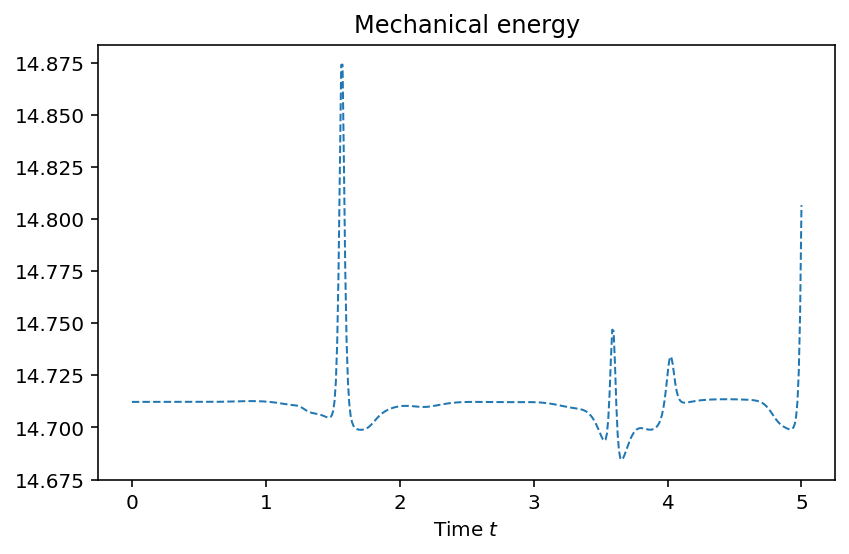

In [21]:
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style()

times = np.linspace(0.0, Tf, int(Tf / timestep))
plt.plot(times, Em_vals, lw=1.0, ls="--")
plt.title("Mechanical energy")
plt.xlabel("Time $t$")
plt.tight_layout()

## Comparison with semi-implicit Euler integration

In [22]:
def semi_implicit_integrator(q0, v0, u, Tf):
    nsteps = int(Tf / timestep)
    x0 = np.concatenate([q0, v0])
    states_ = [x0]
    Em_vals = []
    for t in range(nsteps):
        xc = states_[t]
        qc, vc = xc[: model.nq], xc[model.nq :]

        ac = pin.aba(model, pdata, qc, vc, tau=u)
        vn = vc + ac * timestep
        qn = pin.integrate(model, qc, vn * timestep)
        xn = np.concatenate([qn, vn])

        states_.append(xn)
        e = pin.computeMechanicalEnergy(model, pdata, qn, vn)
        Em_vals.append(e)

    return states_, Em_vals

In [23]:
# use the same q0, v0, u0 as above

states_si, Em_vals_si = semi_implicit_integrator(q0, v0, u=u0, Tf=Tf)

In [24]:
vizer.display(q0)
vizer.viewer.jupyter_cell()

In [25]:
states_si = np.stack(states_si).T

In [26]:
q_traj_si = states_si[: model.nq]

vizer.play(q_traj, timestep)

Text(0.5, 1.0, 'Comparison: mechanical energy conservation')

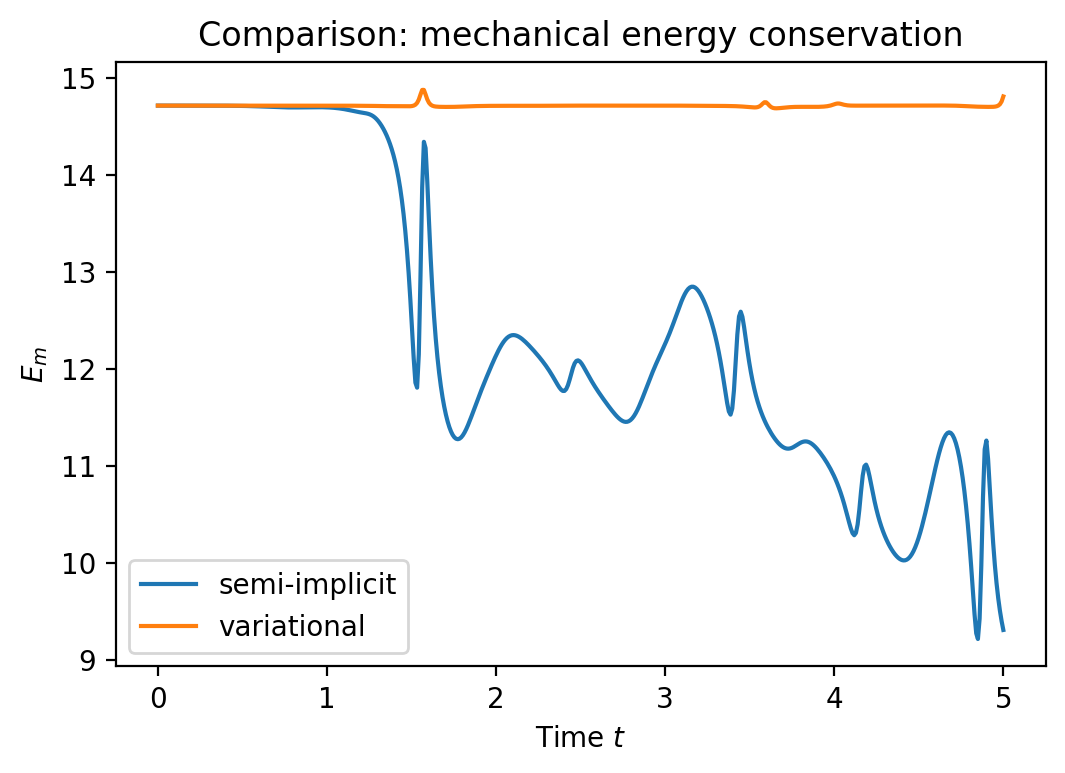

In [27]:
plt.figure(dpi=100)
plt.plot(times, Em_vals_si, label="semi-implicit")
plt.plot(times, Em_vals, label="variational")
plt.xlabel("Time $t$")
plt.ylabel("$E_m$")
plt.legend()
plt.title("Comparison: mechanical energy conservation")

Text(0.5, 0, 'Time $t$')

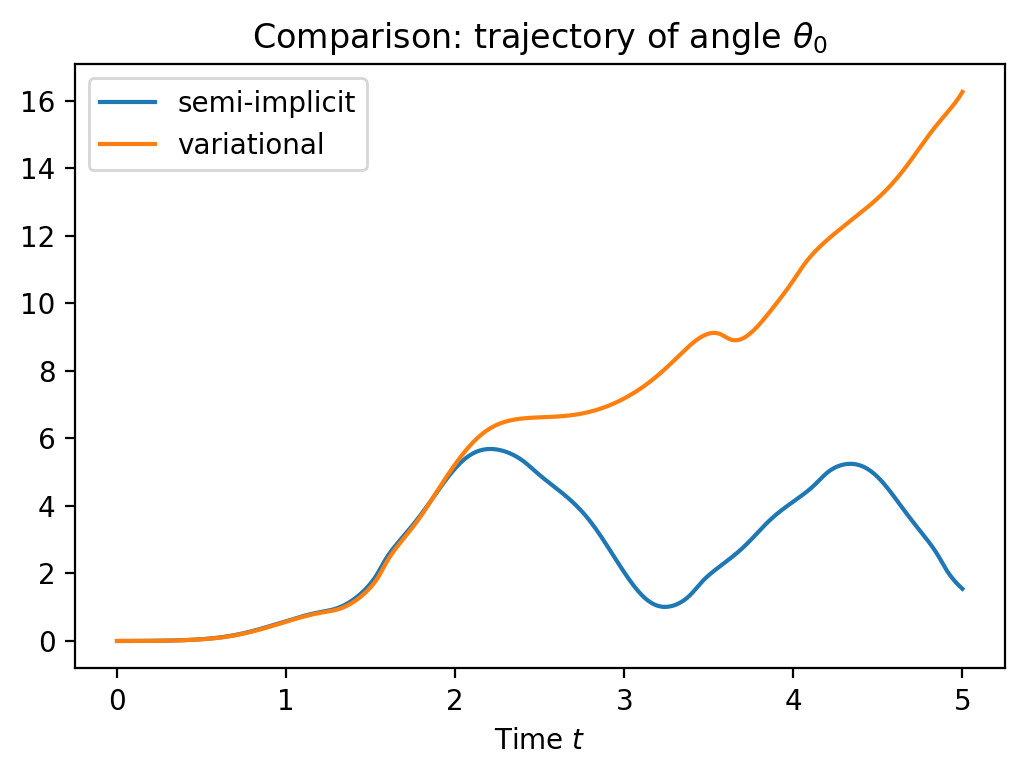

In [28]:
# other comparison: angle theta0
plt.figure(dpi=100)
plt.plot(times, q_traj_si[0, :-1], label="semi-implicit")
plt.plot(times, q_traj[0, :-1], label="variational")
plt.legend()
plt.title(r"Comparison: trajectory of angle $\theta_0$")
plt.xlabel("Time $t$")